# Problem Analysis Workshop 3 — Clustering & K-Means (Fraud Detection)

**Student:** Lesley Wanjiku Kamamo (ID: 8984971)  
**Repo:** ClusteringKMeans_Workshop

> This notebook demonstrates K-Means clustering for a **financial fraud detection** use case:
> setup → data loading → cleaning → EDA → standardization/normalization → feature choice logic → best-k selection (elbow + silhouette) → clustering → interpretation → talking points.


In [2]:
# --- Setup & Configuration ---
import sys, os, json, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
SEED = 42
np.random.seed(SEED)



# Paths
ROOT = Path.cwd()
DATA_DIR = (ROOT / "data")
ARTIFACTS = ROOT / "images"

# plotting defaults
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

print("Python:", sys.version.split()[0])
print("Working dir:", Path.cwd())

Python: 3.12.1
Working dir: e:\CONESTOGA\AI and ML\DataAnalysisMath\ClusteringKMeans_Workshop


### How Clustering Applies (≈ 50 words)
Clustering identifies groups of transactions that behave similarly based on value and channel.  
By analyzing **TransactionAmount** and **Channel**, we uncover spending clusters that differ in magnitude and channel usage.  
Such segmentation supports fraud detection by flagging clusters with unusually high amounts or rare channel combinations for further review.


## Data Loading

We load the transaction dataset from a local file or Kaggle input path.  
Only relevant columns (**TransactionAmount**, **Channel**) are read to save memory.  
We preview a few rows and the data types to confirm successful import.


In [5]:
# Adjust these to your environment
LOCAL_PATH = DATA_DIR / "bank_transactions_data_2.csv"

if LOCAL_PATH.exists():
    data_path = LOCAL_PATH
else:
    data_path = None

print("Using data path:", data_path)

# Load THE dataset
if data_path is not None:
    df = pd.read_csv(data_path, low_memory=False)
else:
    print("Dataset file not found!!")

print("Shape:", df.shape)
display(df.head())
print("\nDtypes:\n", df.dtypes)


Using data path: e:\CONESTOGA\AI and ML\DataAnalysisMath\ClusteringKMeans_Workshop\data\bank_transactions_data_2.csv
Shape: (2512, 16)


,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39



Dtypes:
 TransactionID               object
AccountID                   object
TransactionAmount          float64
TransactionDate             object
TransactionType             object
Location                    object
DeviceID                    object
IP Address                  object
MerchantID                  object
Channel                     object
CustomerAge                  int64
CustomerOccupation          object
TransactionDuration          int64
LoginAttempts                int64
AccountBalance             float64
PreviousTransactionDate     object
dtype: object


### Cleaning & Type Coercion (≤ 5 sentences)
We ensure `TransactionAmount` is numeric and remove invalid or missing entries.  
`Channel` is standardized to uppercase categories for consistent encoding.  
Rows with NaN values are dropped since K-Means requires complete numeric input.


In [6]:
df_clean = df.copy()

# numeric conversion
df_clean["TransactionAmount"] = pd.to_numeric(df_clean["TransactionAmount"], errors="coerce")

# clean channel
df_clean["Channel"] = df_clean["Channel"].astype(str).str.strip().str.upper()

# drop invalid
df_clean = df_clean.dropna(subset=["TransactionAmount", "Channel"])
df_clean = df_clean[df_clean["TransactionAmount"] > 0]

print("After cleaning:", df_clean.shape)
display(df_clean.head())


After cleaning: (2512, 16)


,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,ONLINE,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,ONLINE,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,ONLINE,26,Student,198,1,7429.40,2024-11-04 08:06:39


### Exploratory Data Analysis (≤ 5 sentences)
We compute descriptive statistics and visualize the distribution of transaction amounts across channels.  
Histograms and box plots reveal central tendency, spread, and potential outliers that could indicate fraudulent activity.


count    2512.000000
mean      297.593778
std       291.946243
min         0.260000
25%        81.885000
50%       211.140000
75%       414.527500
max      1919.110000
Name: TransactionAmount, dtype: float64


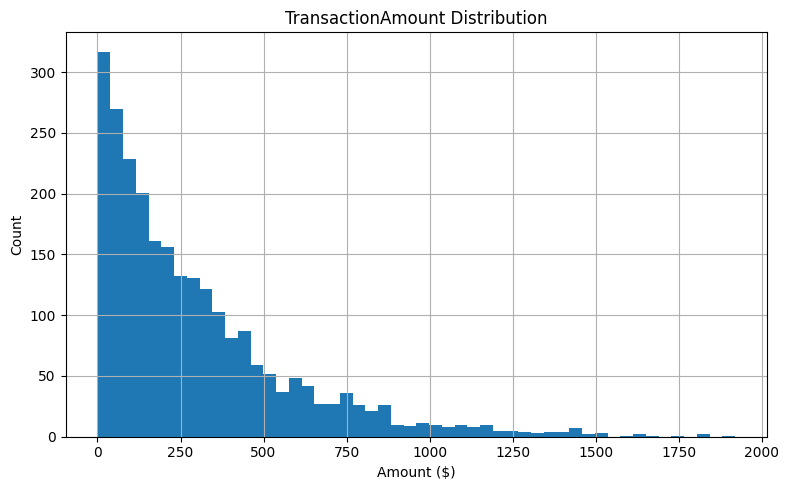

<Figure size 800x500 with 0 Axes>

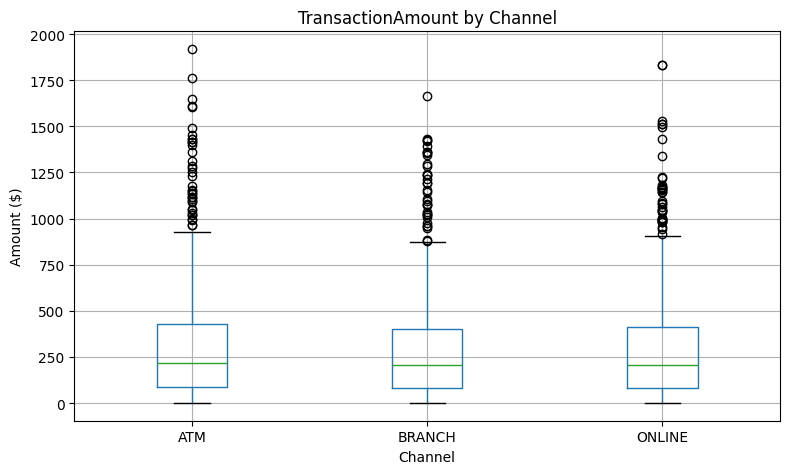

In [7]:
desc = df_clean["TransactionAmount"].describe()
print(desc)

plt.figure()
df_clean["TransactionAmount"].hist(bins=50)
plt.title("TransactionAmount Distribution")
plt.xlabel("Amount ($)")
plt.ylabel("Count")
plt.tight_layout(); plt.show()

plt.figure()
df_clean.boxplot(column="TransactionAmount", by="Channel")
plt.title("TransactionAmount by Channel")
plt.suptitle("")
plt.xlabel("Channel"); plt.ylabel("Amount ($)")
plt.tight_layout(); plt.show()


### Encode Channel for Clustering (≤ 5 sentences)
`Channel` is categorical, so we encode it numerically using **frequency encoding**.  
This assigns higher numeric values to channels with more occurrences.  
It preserves ordinal information for distance-based algorithms like K-Means without expanding dimensions.


In [8]:
# frequency encoding
channel_freq = df_clean["Channel"].value_counts(normalize=True)
df_clean["ChannelFreq"] = df_clean["Channel"].map(channel_freq)

# feature matrix
X = df_clean[["TransactionAmount", "ChannelFreq"]].copy()
display(X.head())


,TransactionAmount,ChannelFreq
0,14.09,0.331608
1,376.24,0.331608
2,126.29,0.322850
3,184.50,0.322850
4,13.45,0.322850


### Standardization (≤ 5 sentences)
Because `TransactionAmount` and `ChannelFreq` are on different scales,  
we standardize them (z-score → mean 0, std 1).  
This ensures K-Means treats both features equally when computing distances.


In [9]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

print("Standardized matrix shape:", X_std.shape)


Standardized matrix shape: (2512, 2)


### Selecting Best *k* (≤ 5 sentences)
We use the **elbow method** (inertia) and **silhouette scores** to identify a good number of clusters.  
The optimal *k* balances low inertia (compact clusters) and high silhouette score (well-separated clusters).


Silhouette by k: {2: 0.5, 3: 0.558, 4: 0.508, 5: 0.5, 6: 0.553, 7: 0.549, 8: 0.587, 9: 0.585}
Best k = 8


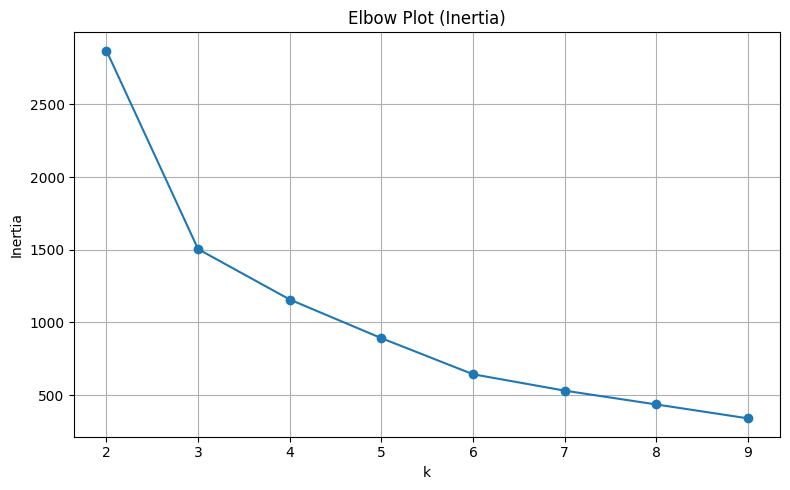

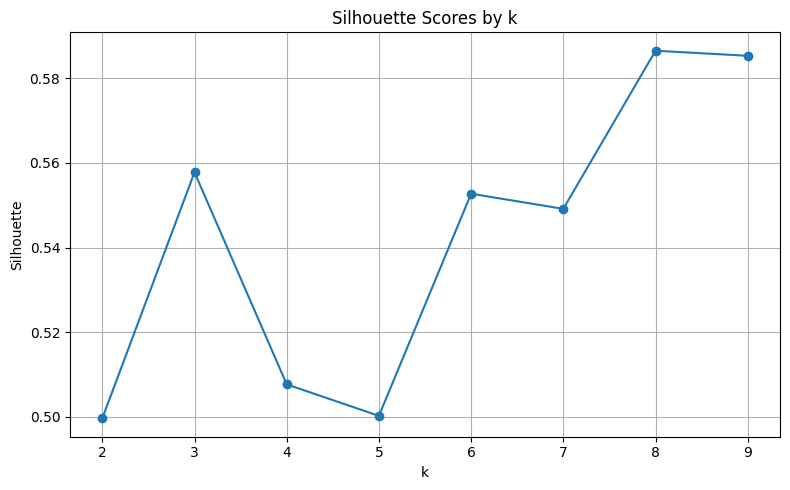

In [10]:
k_range = range(2, 10)
inertias, sils = [], []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    labels = km.fit_predict(X_std)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_std, labels))

best_k = int(k_range[np.argmax(sils)])
print("Silhouette by k:", {k: round(s,3) for k,s in zip(k_range,sils)})
print("Best k =", best_k)

plt.figure()
plt.plot(list(k_range), inertias, marker="o")
plt.title("Elbow Plot (Inertia)")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.tight_layout(); plt.show()

plt.figure()
plt.plot(list(k_range), sils, marker="o")
plt.title("Silhouette Scores by k")
plt.xlabel("k"); plt.ylabel("Silhouette")
plt.tight_layout(); plt.show()


### Fit Final K-Means and Visualize (≤ 5 sentences)
We fit K-Means with the selected *k* and append cluster labels.  
Then we use PCA to reduce dimensions to 2D for visualization and interpretation of cluster structure.


,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate,ChannelFreq,cluster
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08,0.331608,6
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35,0.331608,1
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,ONLINE,19,Student,56,1,1122.35,2024-11-04 08:07:04,0.322850,3
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,ONLINE,26,Student,25,1,8569.06,2024-11-04 08:09:06,0.322850,3
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,ONLINE,26,Student,198,1,7429.40,2024-11-04 08:06:39,0.322850,3


TransactionAmount                                    ChannelFreq  \
                    count         mean    median         std       count   
cluster                                                                    
0                     620   146.338242   126.125  101.370314         620   
1                     270   380.461000   361.595   99.887581         270   
2                      81  1279.227654  1225.500  210.082485          81   
3                     456   104.577829    94.910   69.521466         456   
4                     179   772.558883   745.950  125.917080         179   
5                     219   566.056438   508.730  161.976647         219   
6                     439   100.215376    90.940   69.282523         439   
7                     248   389.304476   373.940   93.686993         248   

                                       
             mean    median       std  
cluster                                
0        0.345541  0.345541  0.000000  
1        0.331608  0.331608  0.000000  
2        0.334542  0.331608  0.008937  
3        0.322850  0.322850  0.000000  
4        0.327303  0.331608  0.004391  
5        0.345541  0.345541  0.000000  
6        0.331608  0.331608  0.000000  
7        0.322850  0.322850  0.000000

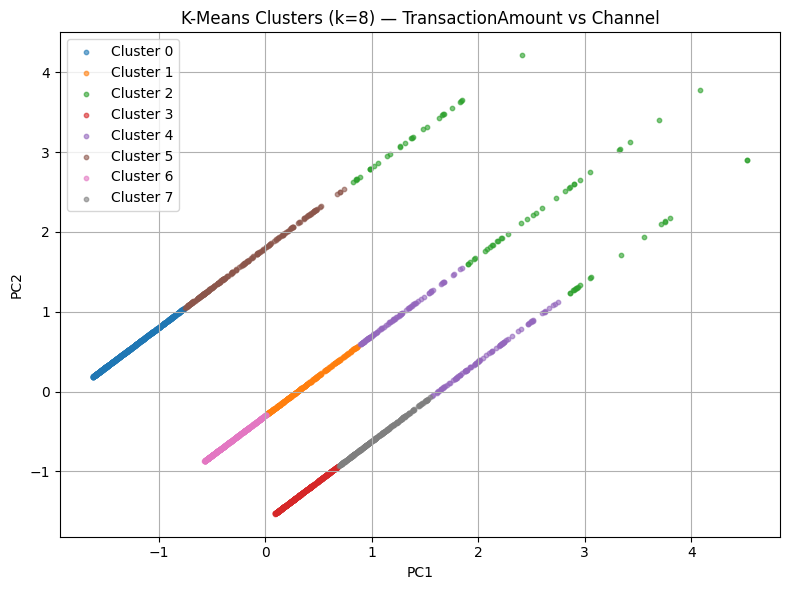

In [11]:
km = KMeans(n_clusters=best_k, random_state=SEED, n_init=10)
labels = km.fit_predict(X_std)

df_clean["cluster"] = labels
display(df_clean.head())

# cluster summary
summary = df_clean.groupby("cluster")[["TransactionAmount","ChannelFreq"]].agg(["count","mean","median","std"])
display(summary)

# PCA visualization
pca = PCA(n_components=2, random_state=SEED)
XY = pca.fit_transform(X_std)

plt.figure(figsize=(8,6))
for c in np.unique(labels):
    plt.scatter(XY[labels==c,0], XY[labels==c,1], s=10, alpha=0.6, label=f"Cluster {c}")
plt.title(f"K-Means Clusters (k={best_k}) — TransactionAmount vs Channel")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.tight_layout(); plt.show()


### K-Means Output Interpretation (≈ 50 words)
Clusters reveal transaction groups with distinct amount ranges and channel usage patterns.  
High-amount transactions from rare channels often signal higher fraud risk,  
while low-amount, frequent-channel clusters represent routine customer behavior.  
Such unsupervised patterns guide fraud teams to prioritize review and enhance supervised risk models.


## Talking Points (for presentation)
- **Goal:** Unsupervised discovery of fraud patterns by amount and channel.  
- **Features:** `TransactionAmount` (magnitude), `ChannelFreq` (channel behavior).  
- **Scaling:** Standardization for fair distance calculations.  
- **Best k:** chosen via silhouette (max separation).  
- **Insight:** High-value, low-frequency channel clusters may indicate potential fraudulent transactions.
